# Programming Assignment \#3
## Eren Akgunduz

In [1]:
import logging
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

In [3]:
# grid of tuning parameters
lambdas = np.logspace(-4, 4, 9)

### Functions

In [4]:
def preprocess_data(filename: str) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")

    try:
        datafile = f"{os.getcwd()}/data/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [5]:
class Begin:
    "Establish design and response matrices"

    def __init__(self, data) -> None:
        self.data: np.ndarray = data
        self.classes: np.ndarray = np.copy(self.data[:, 10])
        self.labels: tuple = tuple(sorted(set(self.classes)))

    def initialize(self) -> tuple:
        # extract the design matrix
        dm = np.array(np.delete(self.data, 10, axis=1), dtype=float)
        # standardize (center & scale)
        dm = (dm - np.mean(dm, axis=0)) / np.std(dm, axis=0)
        aug = np.ones((dm.shape[0], 1))

        X = np.hstack((aug, dm))  # augmented design matrix

        for i, c in enumerate(self.classes):  # encode labels with binarize/one-hot
            if c == self.labels[0]:
                self.classes[i] = np.array([1, 0, 0, 0, 0])
            elif c == self.labels[1]:
                self.classes[i] = np.array([0, 1, 0, 0, 0])
            elif c == self.labels[2]:
                self.classes[i] = np.array([0, 0, 1, 0, 0])
            elif c == self.labels[3]:
                self.classes[i] = np.array([0, 0, 0, 1, 0])
            elif c == self.labels[4]:
                self.classes[i] = np.array([0, 0, 0, 0, 1])
            else:
                self.classes[i] = np.array([0, 0, 0, 0, 0])

        Y = np.vstack(self.classes)  # response matrix

        logger.debug(X.shape)
        logger.debug(X.mean(axis=0))
        logger.debug(X.std(axis=0))
        logger.debug(Y.shape)
        return (X, Y)

In [6]:
def gradient_descent(X, Y, lmbd, a=1e-5) -> np.ndarray:
    "Vectorized batch gradient descent, learning rate alpha, logistic ridge regression"

    def gd(lmbd):
        # starting parameter matrix
        B = np.zeros((X.shape[1], Y.shape[1]))
        for _ in range(10**4):  # total iterations for each tuning parameter
            U = np.exp(X @ B)  # unnormalized class probability matrix
            P = U / U.sum(axis=1, keepdims=True)  # normalized class probability matrix
            Z = np.vstack((B[0], np.zeros((X.shape[1] - 1, Y.shape[1]))))  # intercepts
            B = B + a * (X.T @ (Y - P) - 2 * lmbd * (B - Z))
        return B

    params = np.zeros((9, 11, 5))

    if not isinstance(lmbd, (int, float)):
        for index, val in enumerate(lmbd):
            b = gd(val)
            params[index] = b
    else:
        params = gd(lmbd)
    return params

In [7]:
def cross_validation(data, k: int = 5) -> np.ndarray:
    "Implementation of relevant gradient descent utilizing k-fold cross validation"
    if not isinstance(k, int):
        raise TypeError("Number of folds should be an integer :)")

    # np.random.seed(0)
    data_shuffled = np.random.permutation(data)  # shuffled copy of the original data
    logger.debug(f"{data_shuffled.shape}\n{data_shuffled}")

    # splits row-wise by default, will contain folds of varying shapes
    folds = np.array(np.array_split(data_shuffled, k), dtype=object)

    cv_errors = []
    for index, fold in enumerate(folds):
        logger.debug("\n")
        logger.debug(index)

        train = np.delete(folds, index, axis=0)
        train = np.vstack(train)
        validation = fold
        # logger.debug(f"{train.shape}\n{validation.shape}")
        # logger.debug(train[:1])
        # logger.debug(validation[:1])
        train_X, train_Y = Begin(train).initialize()
        val_X, val_Y = Begin(validation).initialize()
        B = gradient_descent(train_X, train_Y, lambdas)
        # use training parameters to test predictors
        U = np.array([np.exp(val_X @ b) for b in B])
        # normalize the new probability matrices
        P = np.array([u / u.sum(axis=1, keepdims=True) for u in U])
        # now that data is trained and prepared, once again check that things look ok
        logger.debug(f"{lambdas.shape} {P.shape} {val_Y.shape}")
        # obtain categorical cross-entropy loss by multiplying all values element-wise
        cce = np.array([np.sum(val_Y * np.log10(p)) * -(1 / val_Y.shape[0]) for p in P])
        logger.debug(f"{cce.shape}\n{cce}")
        cv_errors.append(cce)

    logger.debug(f"{np.array(cv_errors).T.shape}\n{np.array(cv_errors).T}")
    logger.debug(np.array(cv_errors).T.mean(axis=1))
    return np.array(cv_errors).T.mean(axis=1)

In [8]:
columns, data = preprocess_data("TrainingData_N183_p10.csv")  # unpack the tuple

### Deliverable \#1

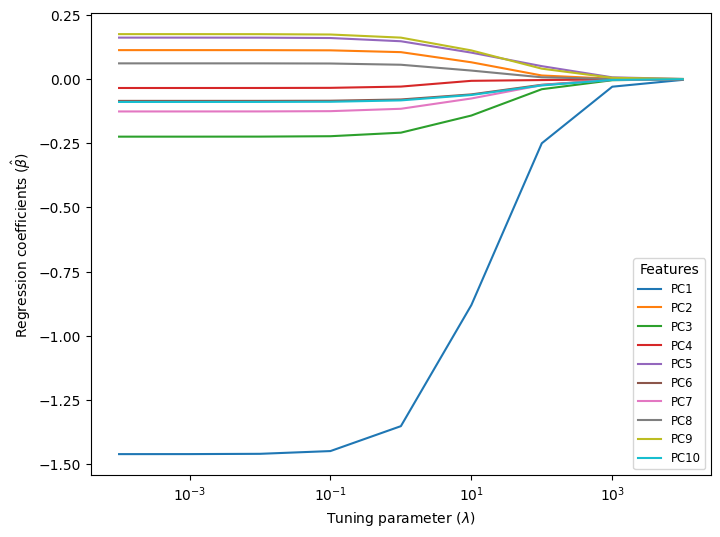

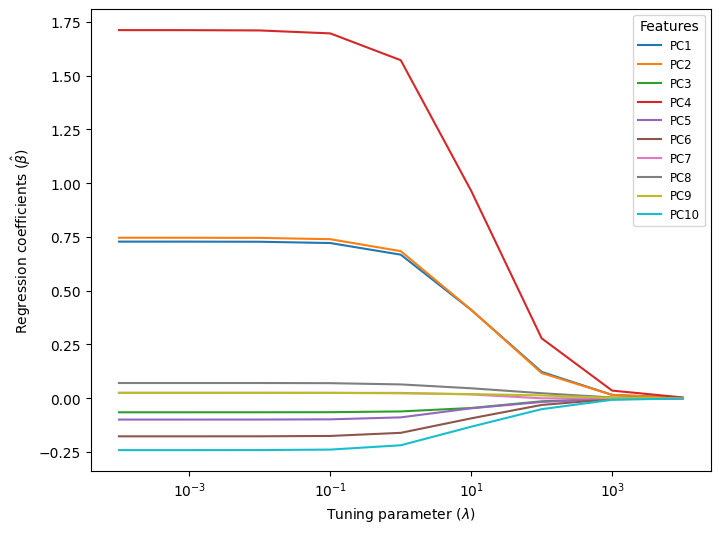

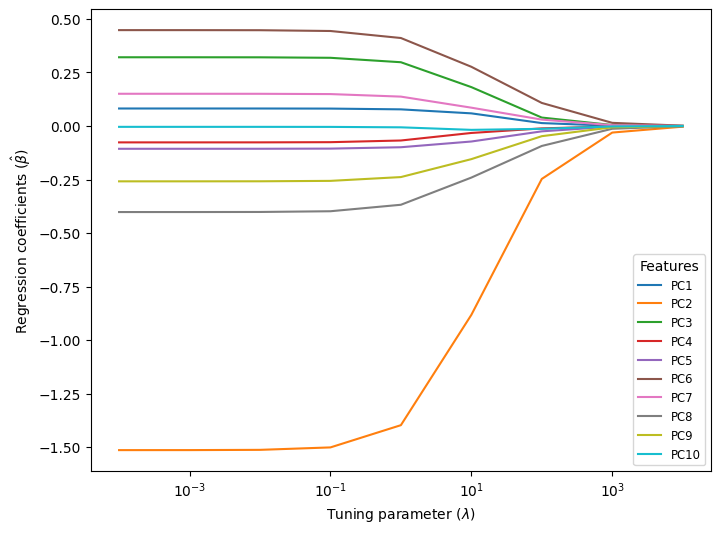

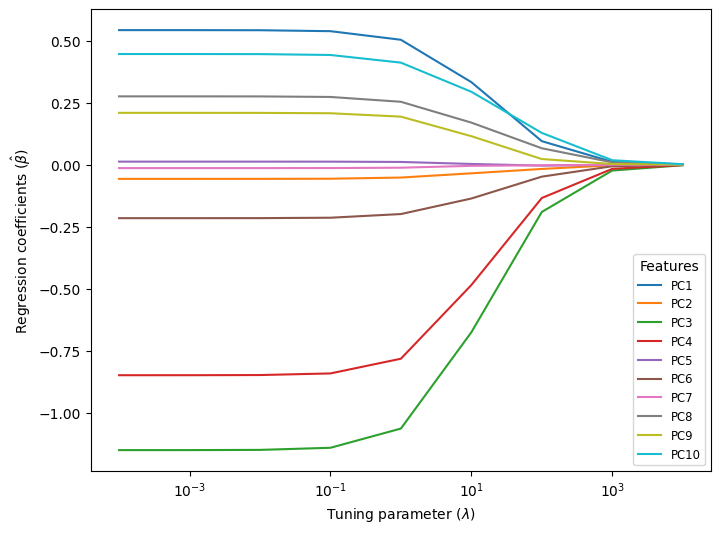

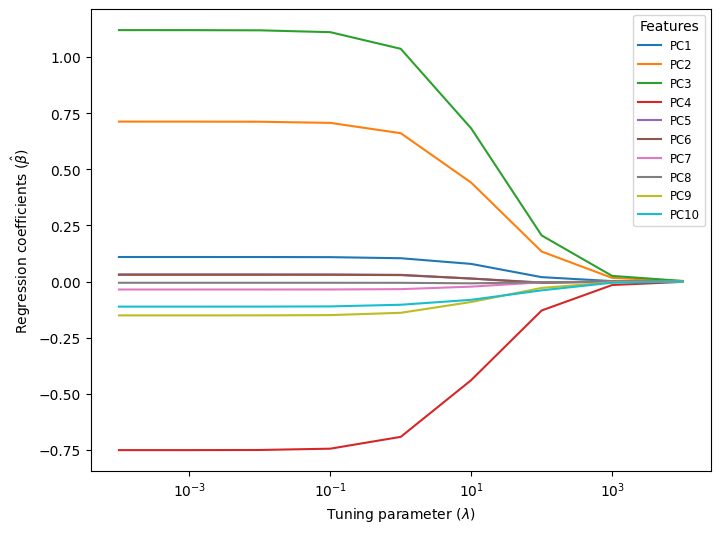

In [9]:
X, Y = Begin(data).initialize()
# transpose so that each row one of the five classes
B = gradient_descent(X, Y, lambdas).T

B_ni = np.zeros((5, 10, 9))  # parameters only, no intercepts
for i, k in enumerate(B):
    B_ni[i] = np.delete(k, 0, axis=0)

for index, cat in enumerate(B_ni):
    plt.figure(figsize=(8, 6))
    plt.xscale("log")
    [plt.plot(lambdas, b, label=f"{columns[i]}") for i, b in enumerate(cat)]
    plt.xlabel(r"Tuning parameter ($\lambda$)")
    plt.ylabel(r"Regression coefficients ($\hat{\beta}$)")
    plt.legend(title="Features", fontsize="small")
    plt.show()

### Deliverable \#2

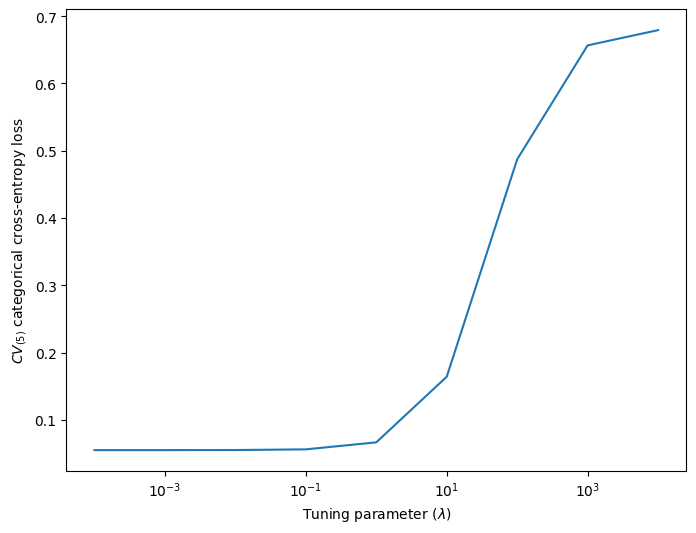

In [10]:
cv_errors = cross_validation(data)
plt.figure(figsize=(8, 6))
plt.xscale("log")
plt.plot(lambdas, cv_errors)
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"$CV_{(5)}$ categorical cross-entropy loss")
plt.show()

### Deliverable \#3

In [11]:
l_optimal = float(lambdas[cv_errors.argmin()])

In [12]:
l_optimal

0.0001

### Deliverable \#4

In [13]:
B = gradient_descent(X, Y, l_optimal)  # retrain model
columns, test_data = preprocess_data("TestData_N111_p10.csv")  # load in test data
test_X, _ = Begin(test_data).initialize()  # discard test responses, don't need them
U = np.exp(test_X @ B)  # use test X and parameters trained with optimal lambda
P = U / U.sum(axis=1, keepdims=True)  # new normalized probability matrix

In [14]:
P.shape  # should be 111x5

(111, 5)

In [15]:
P  # probability for all classes for each observation

array([[2.48642313e-06, 4.73076859e-06, 1.30938536e-06, 2.68151217e-07,
        9.99991205e-01],
       [2.18665542e-04, 4.21963551e-04, 3.50087822e-04, 9.98524483e-01,
        4.84799645e-04],
       [1.81657364e-03, 9.69194041e-02, 8.90061380e-01, 7.88009682e-04,
        1.04146322e-02],
       [3.59100845e-01, 4.10268341e-02, 4.10195922e-03, 8.59652163e-03,
        5.87173840e-01],
       [7.16268921e-06, 9.99980035e-01, 7.48125071e-07, 3.00498795e-06,
        9.04918630e-06],
       [2.57038401e-03, 8.99716675e-04, 1.51343795e-02, 9.79677518e-01,
        1.71800194e-03],
       [5.78472438e-03, 2.87662501e-03, 3.84300438e-02, 9.34285177e-01,
        1.86234301e-02],
       [1.27947220e-02, 4.51659951e-02, 1.73838966e-01, 7.46951887e-01,
        2.12484303e-02],
       [1.58243995e-02, 3.02115524e-02, 5.42390054e-02, 8.86805359e-01,
        1.29196834e-02],
       [1.96099796e-02, 4.05311981e-02, 4.93055424e-01, 4.27706794e-01,
        1.90966044e-02],
       [9.12726340e-03, 3.5651

In [16]:
ordered_probs = P.argsort(axis=1)

In [17]:
ordered_probs  # show indices sorted in order from least to most probable

array([[3, 2, 0, 1, 4],
       [0, 2, 1, 4, 3],
       [3, 0, 4, 1, 2],
       [2, 3, 1, 0, 4],
       [2, 3, 0, 4, 1],
       [1, 4, 0, 2, 3],
       [1, 0, 4, 2, 3],
       [0, 4, 1, 2, 3],
       [4, 0, 1, 2, 3],
       [4, 0, 1, 3, 2],
       [1, 4, 0, 2, 3],
       [0, 4, 3, 1, 2],
       [0, 4, 1, 2, 3],
       [0, 4, 1, 2, 3],
       [0, 1, 2, 4, 3],
       [0, 1, 4, 3, 2],
       [0, 2, 4, 1, 3],
       [0, 1, 2, 4, 3],
       [1, 0, 4, 2, 3],
       [0, 3, 4, 1, 2],
       [0, 4, 3, 1, 2],
       [0, 3, 4, 2, 1],
       [0, 4, 3, 1, 2],
       [1, 0, 4, 2, 3],
       [0, 4, 2, 3, 1],
       [0, 1, 4, 2, 3],
       [4, 0, 1, 2, 3],
       [0, 4, 3, 2, 1],
       [2, 0, 4, 1, 3],
       [3, 0, 4, 1, 2],
       [0, 4, 1, 3, 2],
       [0, 4, 3, 1, 2],
       [0, 4, 2, 3, 1],
       [2, 0, 4, 1, 3],
       [4, 0, 1, 3, 2],
       [0, 4, 2, 3, 1],
       [0, 1, 2, 4, 3],
       [3, 0, 4, 1, 2],
       [0, 1, 2, 4, 3],
       [0, 1, 2, 4, 3],
       [0, 4, 1, 2, 3],
       [0, 4, 2,

In [18]:
P.argmax(axis=1)  # show only the most probable class for observations

array([4, 3, 2, 4, 1, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 1,
       2, 3, 1, 3, 3, 1, 3, 2, 2, 2, 1, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 4, 2, 1, 0, 1, 1, 0, 4, 1,
       1, 1, 1, 0, 0, 0, 1, 4, 1, 4, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 4, 1, 0, 4, 1, 1, 1, 1, 0, 4, 0, 4, 2, 4, 0, 0, 1, 0, 0,
       1])

In [19]:
cmap = plt.get_cmap("plasma")  # set a nice colormap, it's perceptually uniform too

In [20]:
def barplots(op):
    # new list which takes class index and swaps it with corresponding label string
    most_probable = [Begin(data).labels[i] for i in op[:, -1]]
    # data still in order so slice for 5 unknown, 54 Mexican, & 52 African American
    mp_u, mp_mx, mp_aa = (
        most_probable[:5],
        most_probable[5:59],
        most_probable[59:],
    )
    print(mp_u, mp_mx, mp_aa)
    # in order to quickly get & plot the # of observations for each class prediction
    keys_mx, counts_mx = np.unique(mp_mx, return_counts=True)
    keys_aa, counts_aa = np.unique(mp_aa, return_counts=True)

    fig, (ax1, ax2) = plt.subplots(
        1, 2, constrained_layout=True, sharex=True, sharey=True
    )  # establish the figure and two subplots

    ax1.set_title(Begin(test_data).labels[1])  # the string "Mexican"
    # plot bars and apply colormap based on y
    plot1 = ax1.bar(keys_mx, counts_mx, color=cmap(counts_mx))
    ax1.bar_label(plot1)  # add labels so we can see exact # for each class
    # f"{Begin(test_data).labels[0][:7]} {Begin(test_data).labels[0][7:]}" works too
    ax2.set_title("African American")  # but this is much easier+cleaner
    plot2 = ax2.bar(keys_aa, counts_aa, color=cmap(counts_aa))
    ax2.bar_label(plot2)

    fig.suptitle("Model results for most probable ancestry label of test data")
    fig.supxlabel("Training labels")
    fig.supylabel("# of observations")
    fig.set_size_inches(12, 7.5)
    return plt.show()

['Oceanian', 'NativeAmerican', 'European', 'Oceanian', 'EastAsian'] ['NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'European', 'EastAsian', 'European', 'NativeAmerican', 'EastAsian', 'NativeAmerican', 'NativeAmerican', 'EastAsian', 'NativeAmerican', 'European', 'European', 'European', 'EastAsian', 'NativeAmerican', 'European', 'EastAsian', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'European', 'European', 'NativeAmerican', 'European', 'European', 'European', 'European', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'Oceanian', 'European'] ['EastAsian', 'African', 'EastAsian', 'EastAsian', 'African', 'Oceanian', 'EastAsian', 'EastAsian', 'EastAsian

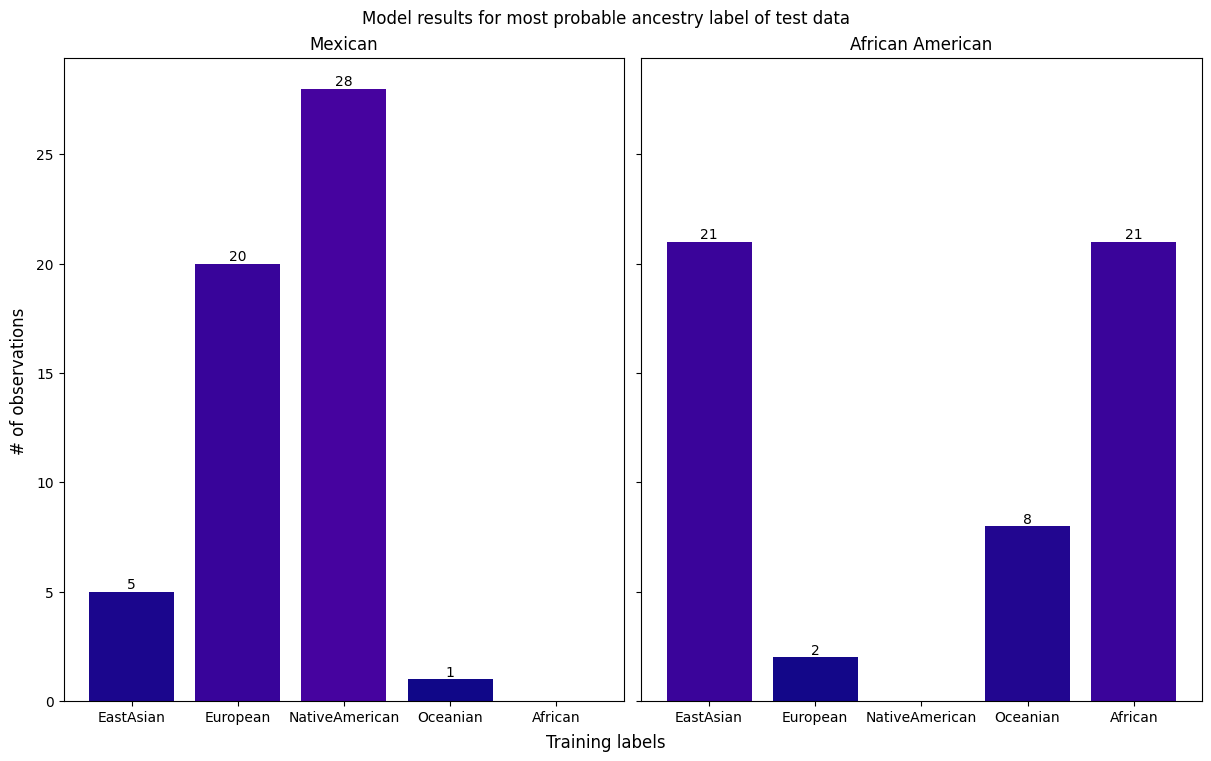

In [21]:
bars_og = barplots(ordered_probs)  # plot the original predictions of most probable

#### Testing the difference made by a small adjustment

In [22]:
for i, probs in enumerate(ordered_probs[59:]):  # correction for African Americans
    if probs[4] == 1:  # was curious to see if the most probable label is East Asian
        ordered_probs[59:][i][4] = probs[3]  # then we swap w/ the 2nd most probable

['Oceanian', 'NativeAmerican', 'European', 'Oceanian', 'EastAsian'] ['NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'European', 'EastAsian', 'European', 'NativeAmerican', 'EastAsian', 'NativeAmerican', 'NativeAmerican', 'EastAsian', 'NativeAmerican', 'European', 'European', 'European', 'EastAsian', 'NativeAmerican', 'European', 'EastAsian', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'NativeAmerican', 'European', 'European', 'European', 'NativeAmerican', 'European', 'European', 'European', 'European', 'NativeAmerican', 'European', 'NativeAmerican', 'NativeAmerican', 'Oceanian', 'European'] ['African', 'African', 'African', 'African', 'African', 'Oceanian', 'African', 'African', 'European', 'Europea

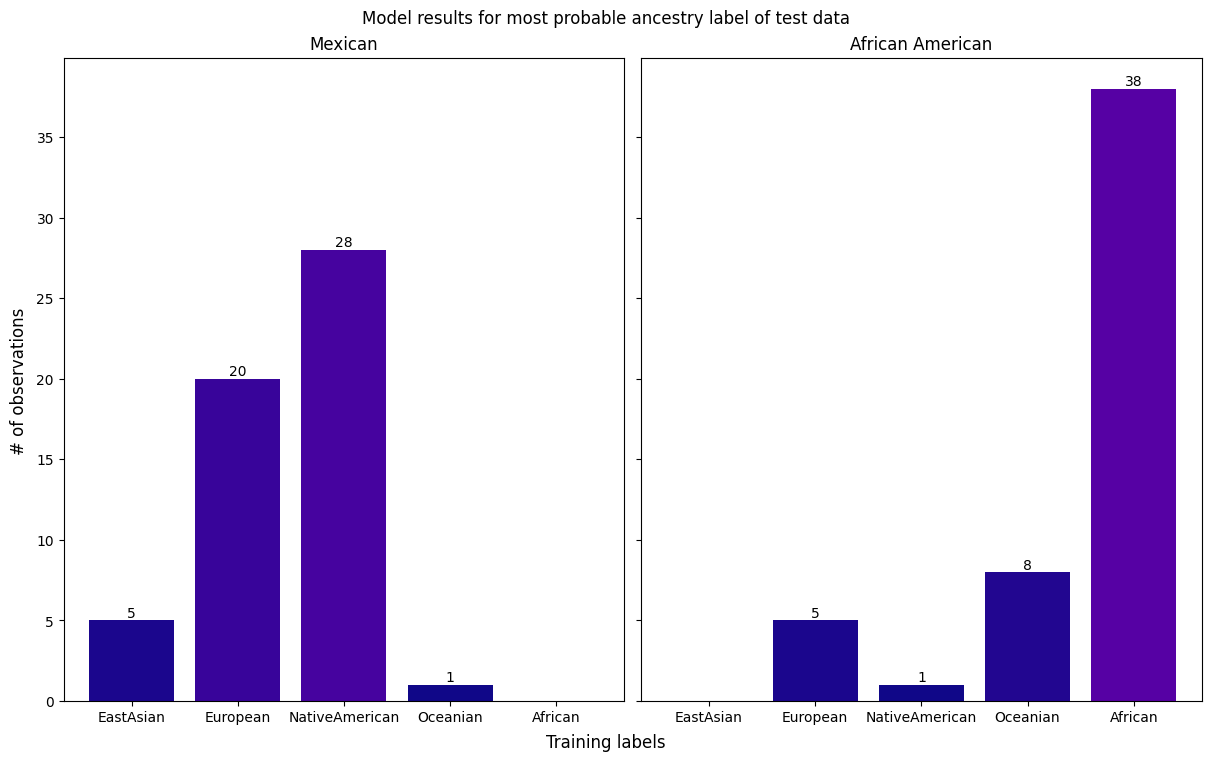

In [23]:
bars_sb = barplots(ordered_probs)  # plot again, now with substitutions applied

#### Donut plots

In [24]:
# prepare the array again, this time for donut plots
most_probable = [Begin(data).labels[i] for i in ordered_probs[:, -1]]
mp_mx, mp_aa = (most_probable[5:59], most_probable[59:])
keys_mx, counts_mx = np.unique(mp_mx, return_counts=True)
keys_aa, counts_aa = np.unique(mp_aa, return_counts=True)

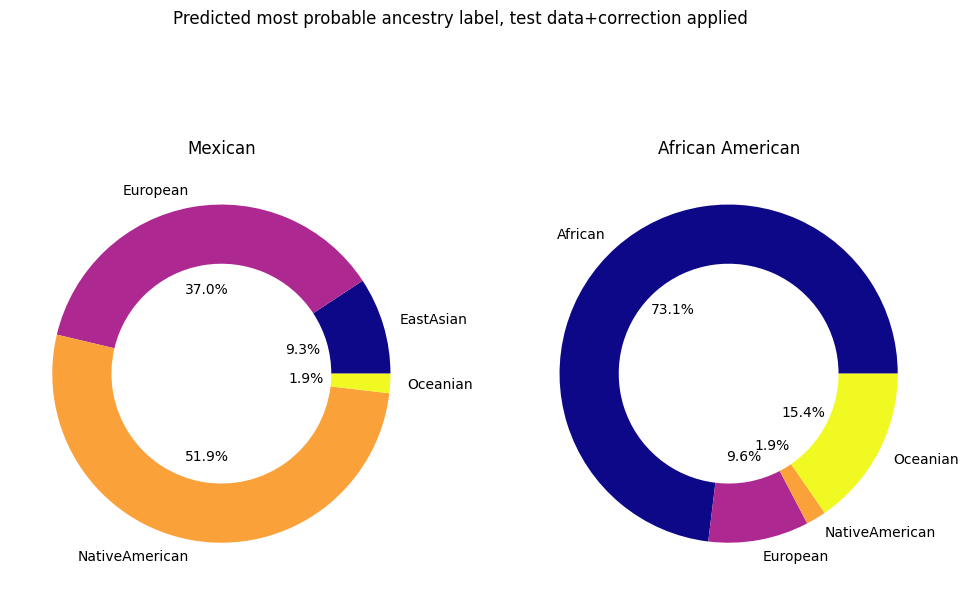

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title(Begin(test_data).labels[1])
ax1.pie(
    counts_mx,
    labels=keys_mx,
    autopct="%1.1f%%",
    pctdistance=0.5,
    colors=cmap(np.arange(keys_mx.shape[0]) * 100),
    wedgeprops={"width": 0.35},
)
ax2.set_title("African American")
ax2.pie(
    counts_aa,
    labels=keys_aa,
    autopct="%1.1f%%",
    pctdistance=0.5,
    colors=cmap(np.arange(keys_aa.shape[0]) * 100),
    wedgeprops={"width": 0.35},
)
fig.suptitle("Predicted most probable ancestry label, test data+correction applied")
fig.set_size_inches(12, 7.5)
plt.show()

### Deliverable \#5

Unlike how the most probable labels for the \[five\] unknown samples nearly contain a representative for each of the five classes (with only African missing, which may be due to misclassification for one of the individuals), the distributions of class label probabilities for both the Mexican and African American sample groups appear to exhibit unique characteristics. In fact, these distinct qualities could be expected in relation to, and explained by, historical events &mdash; both serving as a reflection of the outcomes of European colonization and its various practices in the Americas.

Across the regions considered part of Latin America today, including in Mexico, mixing between the colonizers and settlers from the Iberian Peninsula and the indigenous population was very commonplace &mdash; to such an extent that a complex system of labels to classify mixed-race individuals based on their particular lineage, called *castas*, developed before long. Evidently, the prevalent *mestizo* identity of present-day Mexico, illustrated concurrently in both the primary cultural dimension within Mexican society, as well as in terms of the typically mixed heritages of the vast majority of the current Mexican population &mdash; with this genetic composition aspect acting as one feature that those outside Mexico often recognize as a key trait of 'mestizo' Mexicans &mdash; is a quality that the model clearly seems to corroborate with its most frequently occurring probable label selections; namely Native American (from the indigenous civilizations and their peoples) and European (from the Spanish conquistadors and colonists).

By contrast, the most probable label-based classification of the African American individuals in the test data yielding (after correcting for East Asian-classified samples with the second most probable label) predominantly African as the result (for almost three-quarters of the samples), with the remaining exceptions mainly divided among the European and Oceanian labels. While this is certainly reasonable when considering the history, it does contribute towards painting a very different picture from the Mexican example. Egregious practices such as the Atlantic slave trade and chattel slavery meant that a tremendous number of primarily West African individuals were enslaved and involuntarily transported from their homeland to the colonies of the Americas &mdash; and from the 17th century onwards, British North America and many of those colonies which later became part of the United States, were no exception.

The context by which these Africans found themselves in the present-day U.S. played a fundamental role in the way that white authority figures viewed interracial relationships with African Americans involved &mdash; these were both heavily stigmatized and in certain jurisdictions even outright forbidden. Even after the end of slave importation to the U.S., and the end of slavery altogether decades later with the conclusion of the American Civil War, blatantly racist policies (Jim Crow laws) and public conceptualizations (such as the "one-drop rule") and sentiments/attitudes persisted for more than an entire century afterwards (and, although to a much more limited extent, remain to this day), which came with many consequences in society. One of these effects was certainly how the prevalence of African Americans mixing with those outside their community remained highly limited for a long time. With that said, biracial and multiracial individuals who have a mixed African/Black and European/White, or Black and Oceanian \[Pacific Islander\] heritage, are still very far from unheard of, and I think that individuals for whom these descriptions are valid might account for the proportion of samples the model did not classify as most probably African.